# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [140]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

In [141]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [142]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [143]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [144]:
# Getting the data from the top 10 expensive neighbourhoods
to_data_grouped_by_neigbhourhood = to_data.groupby( ['neighbourhood']).mean().reset_index()
to_data_grouped_by_neigbhourhood = to_data_grouped_by_neigbhourhood.sort_values(by='average_house_value',ascending=False)
expensive_neighbourhoods = to_data_grouped_by_neigbhourhood.head(10)

# Calculate the mean number of dwelling types units per year
dwelling_types_per_year =  to_data.iloc[:, : 9].reset_index().groupby('year').sum()


# Calculate the average monthly shelter costs for owned and rented dwellings
avg_monthly_shelter_cost =  to_data.iloc[:, -2: ].reset_index().groupby('year').mean()

### Panel Visualization Functions

In [145]:
# Define Panel visualization functions
def neighbourhood_map():
    mean_values_per_neigbhourhood = to_data.groupby( ['neighbourhood']).mean()
    merged_df = pd.concat(
        [df_neighbourhood_locations.set_index('neighbourhood'), 
        mean_values_per_neigbhourhood], 
        axis=1,  
        join='inner').reset_index()
    map = px.scatter_mapbox(
        merged_df,
        lat="lat",
        lon="lon",
        size="shelter_costs_owned",
        color="shelter_costs_owned",
        zoom=4
    )
    return map    

def create_bar_chart(data, title, xlabel, ylabel, color):
    """
    Create a barplot based in the data argument.
    """
    bar_plt = data.plot.bar(title=title, rot=90, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.close()
    return bar_plt

def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """
    line_plt = data.plot.line(title=title,  color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.close()
    return line_plt
       

def average_house_value():
    """Average house values per year."""
    avg_yearly_house_value = to_data.loc[:, 'average_house_value'].reset_index().groupby('year').mean()
    line_plt = avg_yearly_house_value.plot.line(title="Average Hose Value in Toronto", legend=False)
    plt.ylabel('Avg. House Value')
    plt.close()
    return line_plt
def average_value_by_neighbourhood():
    """Average house values by neighbourhood."""
    to_data_grouped = to_data.loc[:, ['neighbourhood','average_house_value']].reset_index().groupby( ['year','neighbourhood']).mean().reset_index()
    line_plt = to_data_grouped.hvplot.line(x='year', y='average_house_value', groupby='neighbourhood')
    plt.close()
    return line_plt

def number_dwelling_types():
    """Number of dwelling types per year"""
    all_dwelling_types = to_data.reset_index()
    bar_plt = all_dwelling_types.iloc[:,:10].hvplot.bar(x='year', groupby='neighbourhood', stacked=False, rot=90, height=500)
    plt.close()
    return bar_plt

def average_house_value_snapshot():
    """Average house value for all Toronto's neighbourhoods per year."""
    all_dwelling_types = to_data.reset_index()
    value_snapshot = px.bar(all_dwelling_types, x="neighbourhood", y="average_house_value", facet_row="year" , color="average_house_value", height = 1000)
    plt.close()
    return value_snapshot

def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    expensive_neighbourhoods_plt = expensive_neighbourhoods.head(10).hvplot.bar(x='neighbourhood', y='average_house_value', rot=90, height=500)
    plt.close()
    return expensive_neighbourhoods_plt

def sunburts_cost_analysis():
    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""
    fig =px.sunburst(
    expensive_neighbourhoods,
    names='neighbourhood',
    values= 'shelter_costs_owned',
    color='shelter_costs_owned',
    )
    return fig

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [161]:
# Create a Title for the Dashboard
dashboard_title = "#Real Estate Analysis of Toronto from 2001 to 2016"

# Define a welcome text
message = "##This dashboard goes over key data points of the toronto relaestate market from the years 2001 to 2016"


In [162]:
# Creating panel for Welcome Tab
welcome_tab = pn.Column(
    message,
    neighbourhood_map()
)

In [163]:
# Creating panel charts for Yearly Market Analysis Tab
# Bar chart for 2001
Dwelling_types_2001 = create_bar_chart(dwelling_types_per_year.loc[2001], "Dwelling Types in Toronto 2001" ,"2001",  "Dwelling Type Units",  'red')
# Bar chart for 2006
Dwelling_types_2006 =create_bar_chart(dwelling_types_per_year.loc[2006], "Dwelling Types in Toronto 2006" ,"2006",  "Dwelling Type Units",  'blue')
# Bar chart for 2011
Dwelling_types_2011 =create_bar_chart(dwelling_types_per_year.loc[2011], "Dwelling Types in Toronto 2011" ,"2011",  "Dwelling Type Units",  'yellow')
# Bar chart for 2016
Dwelling_types_2016 =create_bar_chart(dwelling_types_per_year.loc[2016], "Dwelling Types in Toronto 2016" ,"2016",  "Dwelling Type Units",  'purple')

tab2_row1 = pn.Row(Dwelling_types_2001.figure, Dwelling_types_2006.figure)
tab2_row2 = pn.Row(Dwelling_types_2011.figure, Dwelling_types_2016.figure)
Year_Market_Analysis_Tab = pn.Column(
    tab2_row1,
    tab2_row2)


In [164]:
# Creating line charts for Shelter Cost vs House Value tab
# Line chart for owned dwellings
owned_dwelings = create_line_chart(
    avg_monthly_shelter_cost.loc[:,'shelter_costs_owned'], 
    "Average Monthly Chelter Cost for Owned Dwelings in Toronto" ,
    "Year",  
    "Average Monthly Chelter Costs",  
    'blue'
)
# Line chart for rented dwellings
rented_dweliings = create_line_chart(
    avg_monthly_shelter_cost.loc[:,'shelter_costs_rented'], 
    "Average Monthly Chelter Cost for Rented Dwelings in Toronto" ,
    "Year",  
    "Average Monthly Chelter Costs",  
    'yellow'
)
avg_house_value = average_house_value()
Shelter_Cost_vs_House_Value_tab = pn.Column(
    owned_dwelings.figure,
    rented_dweliings.figure,
    avg_house_value.figure)


In [165]:
#creating panel for Neighbourhood Analysis tab
avg_value_by_neighbourhood = average_value_by_neighbourhood()
num_dwelling_types = number_dwelling_types()
value_snapshot = average_house_value_snapshot()
tab4_column_1 = pn.Column(
    avg_value_by_neighbourhood,
    num_dwelling_types,)
Neighbourhood_Analysis_tab = pn.Row(tab4_column_1, value_snapshot) #Please see the debug to see that value_snapshot is working

In [166]:
#creating panel for top expensive neighbourhoods tab
top_most_expensive_neighbourhoods_plt = top_most_expensive_neighbourhoods()
sun_brst = sunburts_cost_analysis()
expensive_neighbourhoods_tab = pn.Row(top_most_expensive_neighbourhoods_plt,sun_brst )

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Column
            [0] Row
                [0] Matplotlib(Figure)
                [1] Matplotlib(Figure)
            [1] Row
                [0] Matplotlib(Figure)
                [1] Matplotlib(Figure)
        [2] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [3] Row
            [0] Column
                [0] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
                [1] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
            [1] Plotly(Figure)
        [4] Row
            [0] HoloViews(Bars)
            [1] Plotly(Figure)
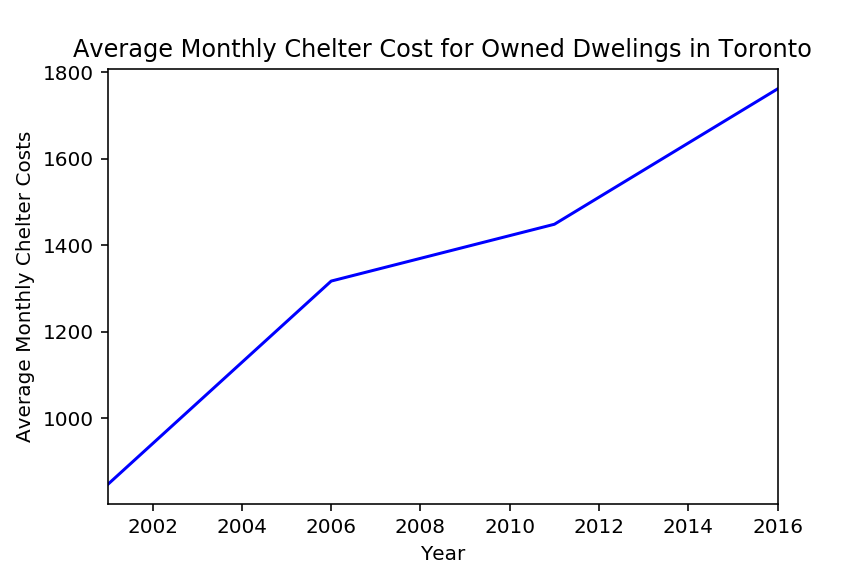
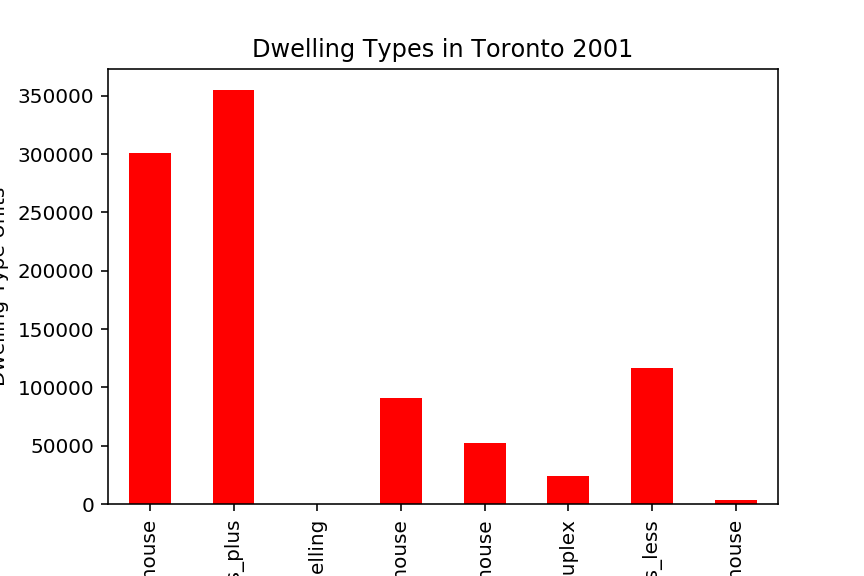
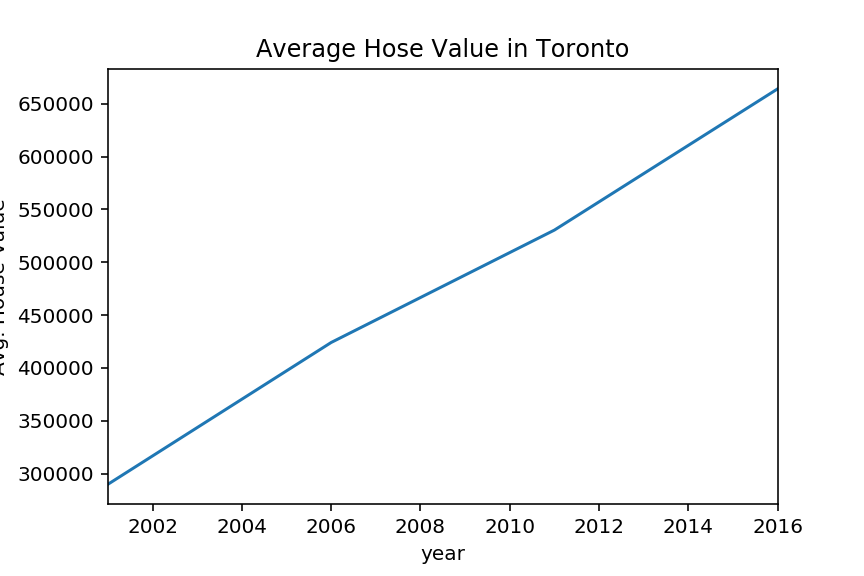
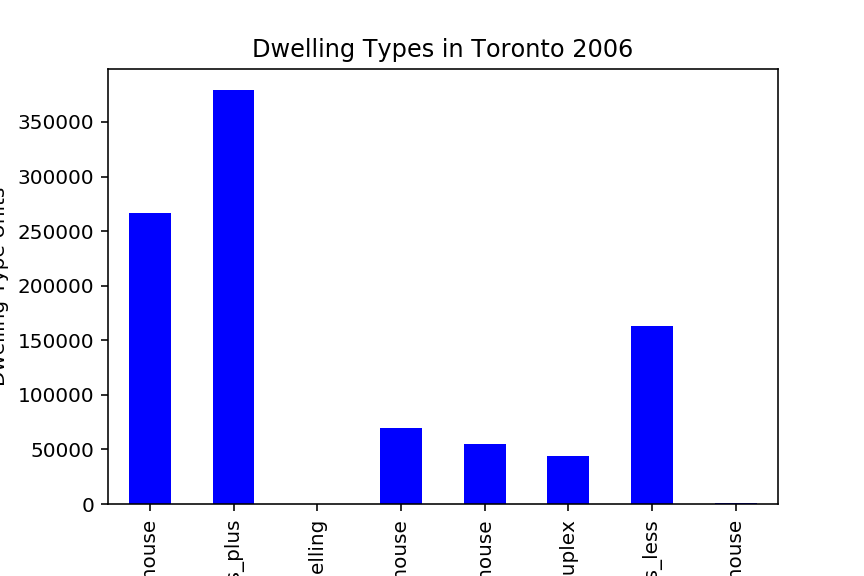
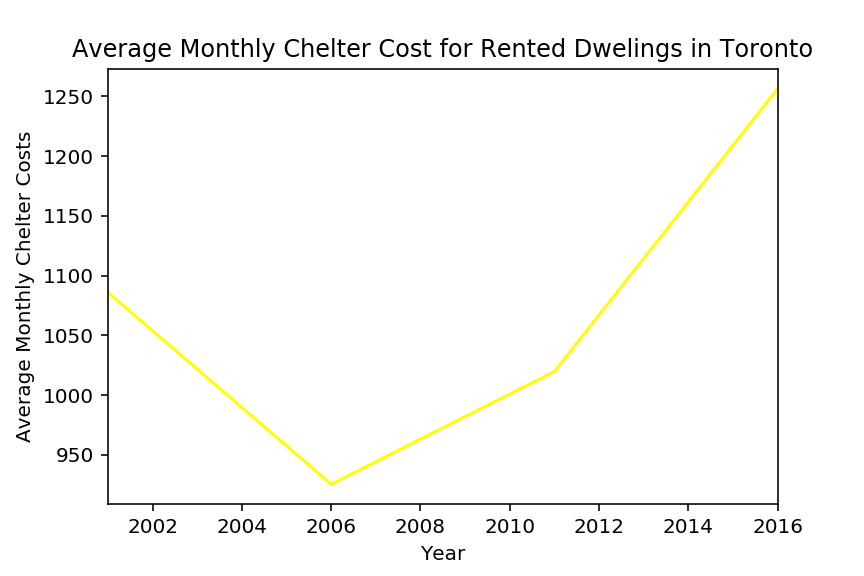
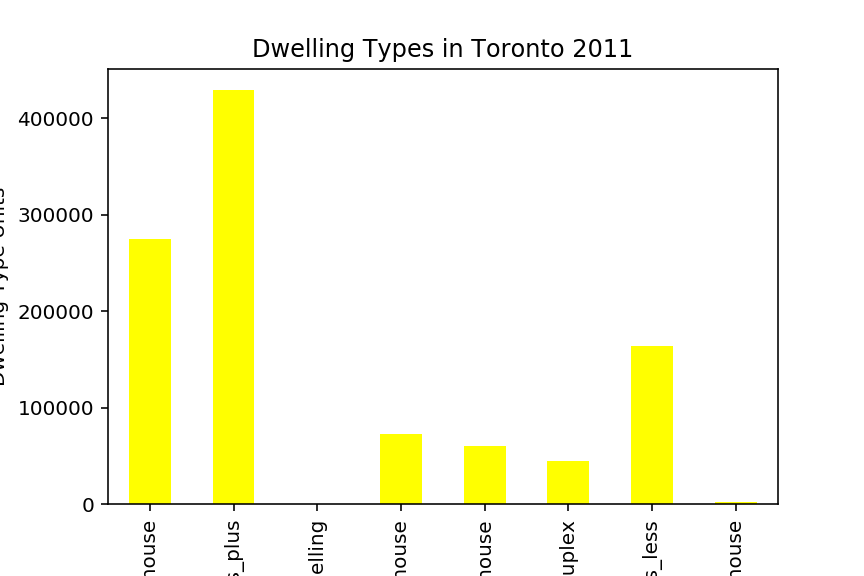
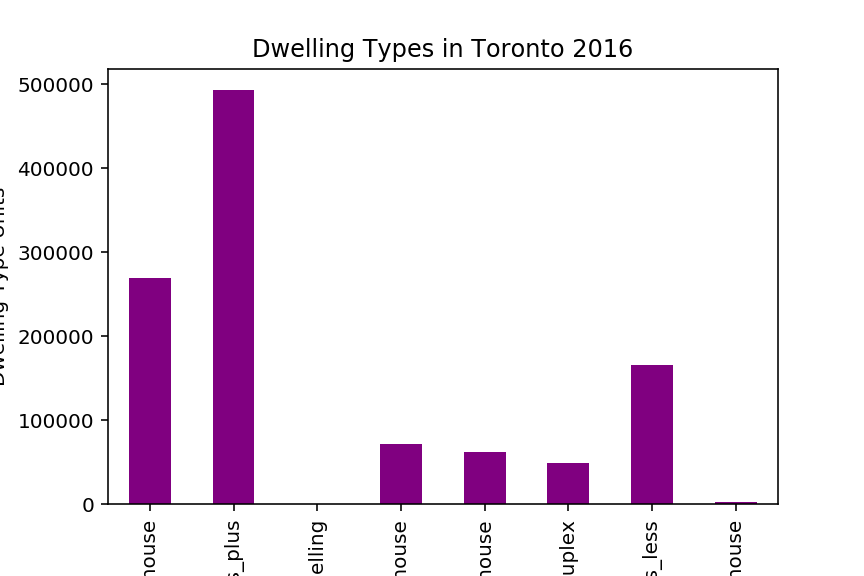

In [167]:
#Putting together the dashboard
dashboard_tabs = pn.Tabs(
    ("Welcome", welcome_tab), 
    ("Yearly Market Analysis", Year_Market_Analysis_Tab),
    ("Shelter Cost vs House Value tab", Shelter_Cost_vs_House_Value_tab),
    ("Neighbourhood Analysis", Neighbourhood_Analysis_tab),
    ("top expensive neighbourhoods", expensive_neighbourhoods_tab)
)
dashboard = pn.Column(
    dashboard_title,
    dashboard_tabs
)
dashboard

## Serve the Panel Dashboard

Column
    [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Column
            [0] Row
                [0] Matplotlib(Figure)
                [1] Matplotlib(Figure)
            [1] Row
                [0] Matplotlib(Figure)
                [1] Matplotlib(Figure)
        [2] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [3] Row
            [0] Column
                [0] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
                [1] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
            [1] Plotly(Figure)
        [4] Row
            [0] HoloViews(Bars)
            [1] Plotly(Figure)
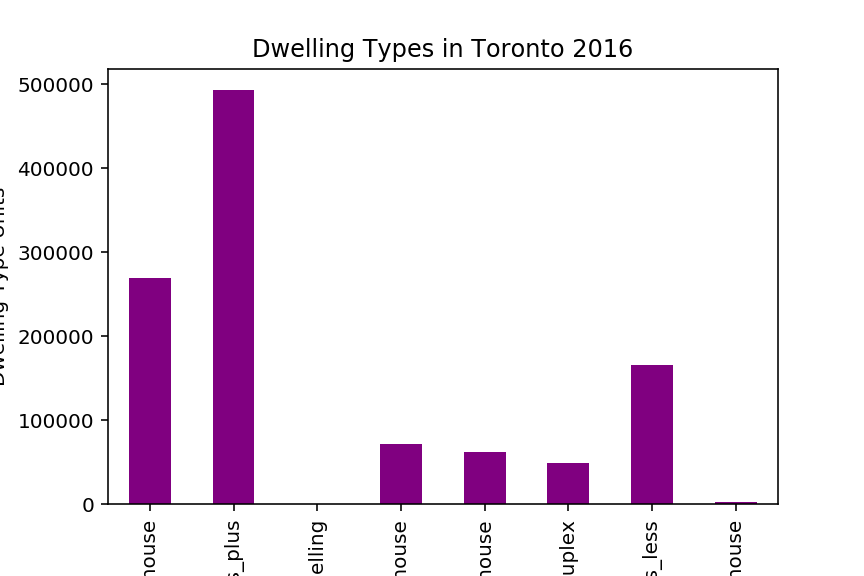
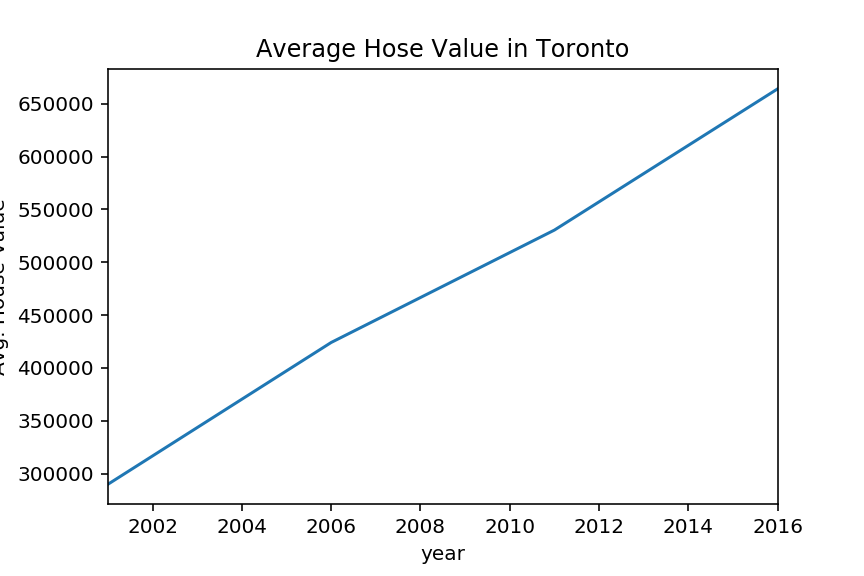
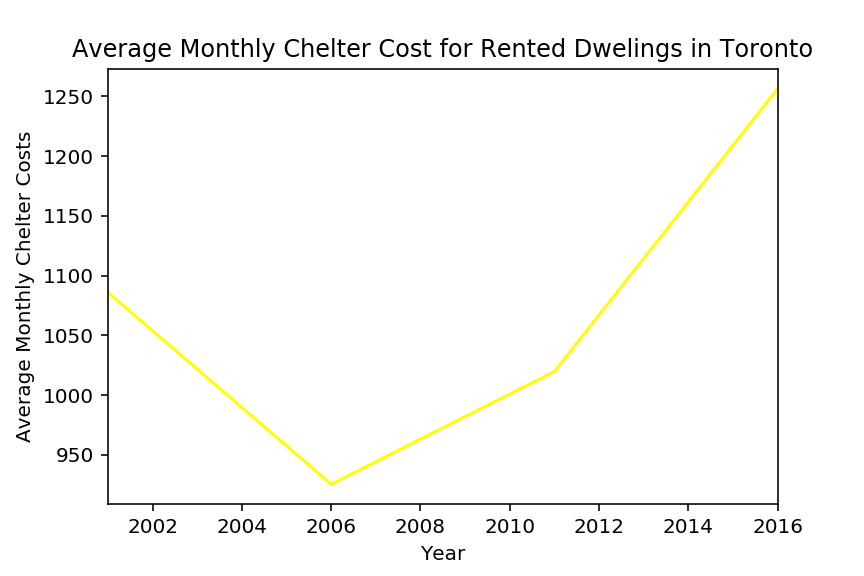
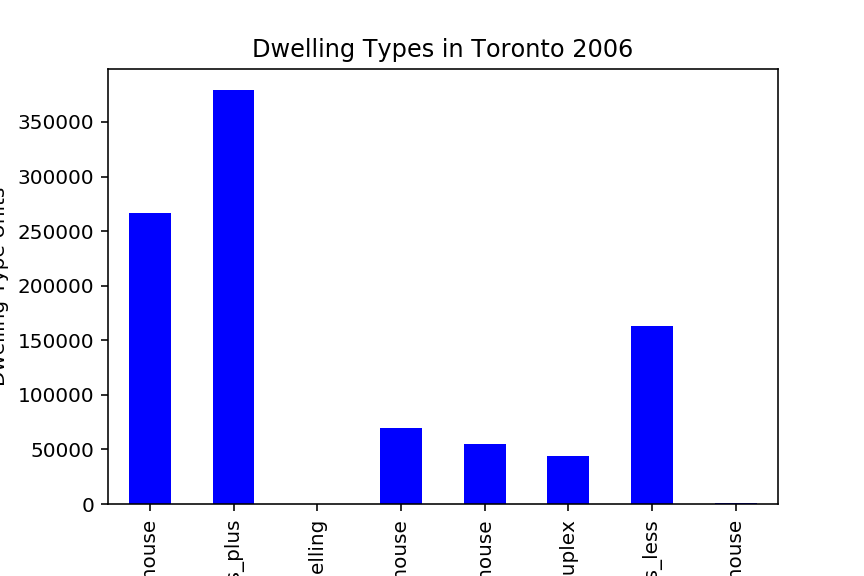
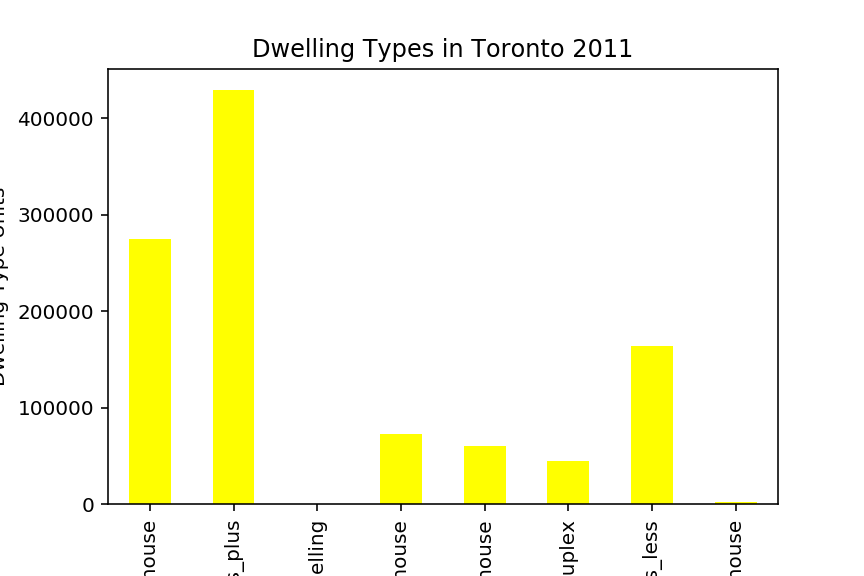
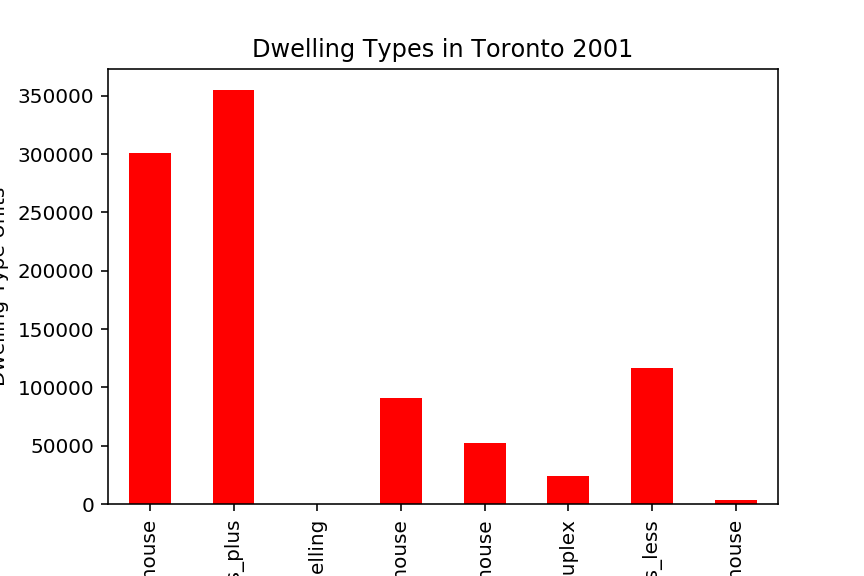
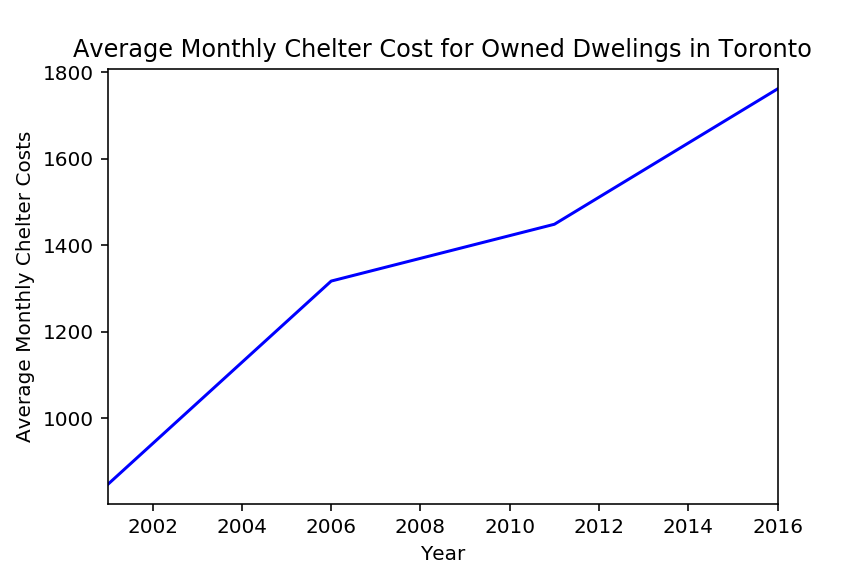

In [168]:
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

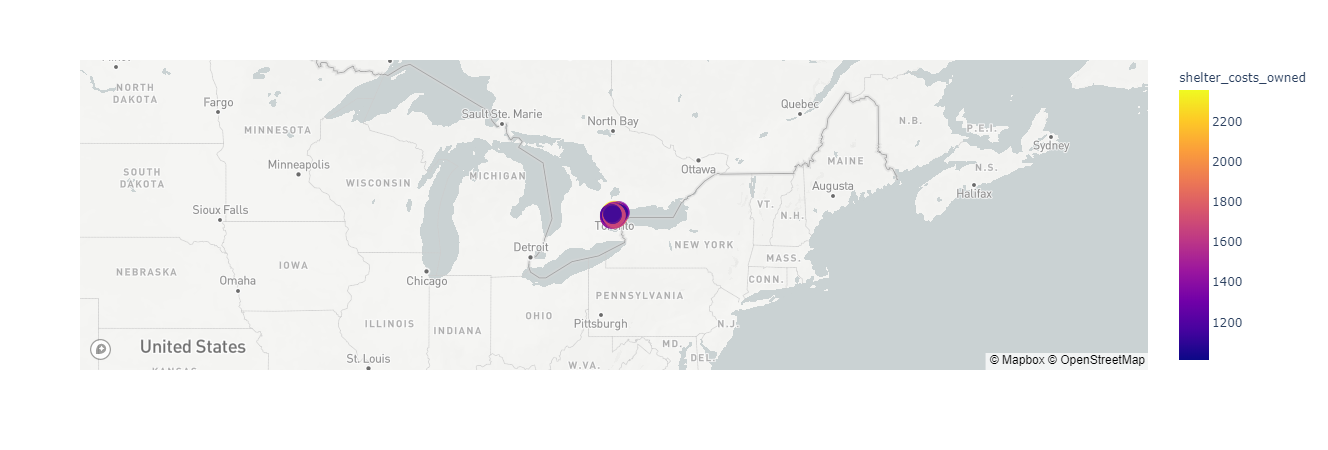

In [157]:
# neighbourhood_map().show()
neighbourhood_map()

In [10]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
# create_bar_chart(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [11]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(df_avg_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [12]:
# average_house_value()

In [13]:
# average_value_by_neighbourhood()

In [14]:
# number_dwelling_types()

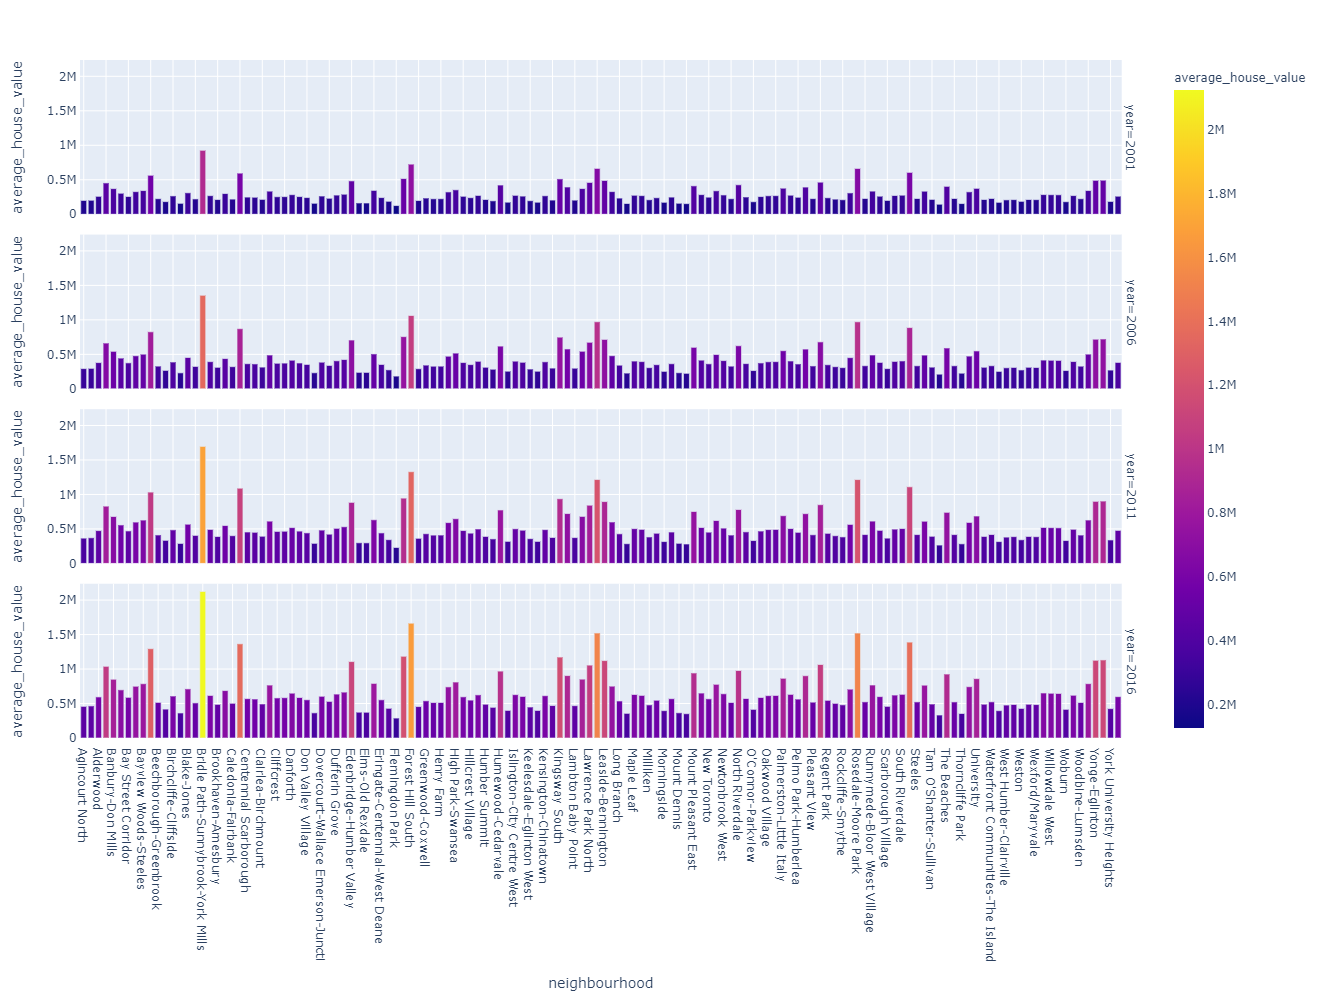

In [112]:
# average_house_value_snapshot()
value_snapshot

In [136]:
# top_most_expensive_neighbourhoods()


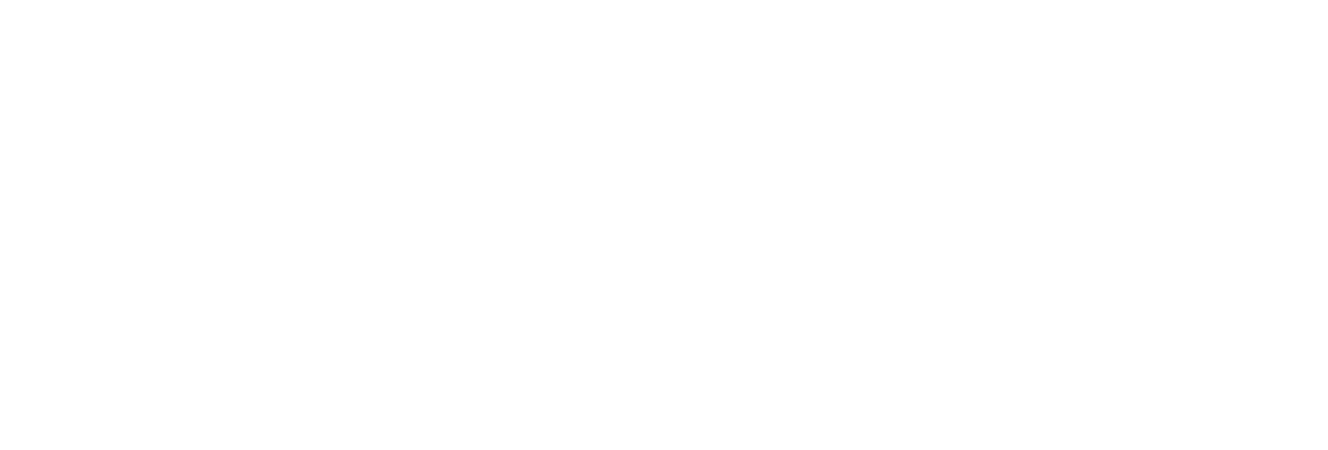

In [158]:
# sunburts_cost_analysis()
sunburts_cost_analysis()